In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
dataset_path = "../data/asl_alphabet_train/asl_alphabet_train"

In [3]:
classes = sorted(os.listdir(dataset_path))
print("Classes:", classes)
print("Total classes:", len(classes))

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Total classes: 29


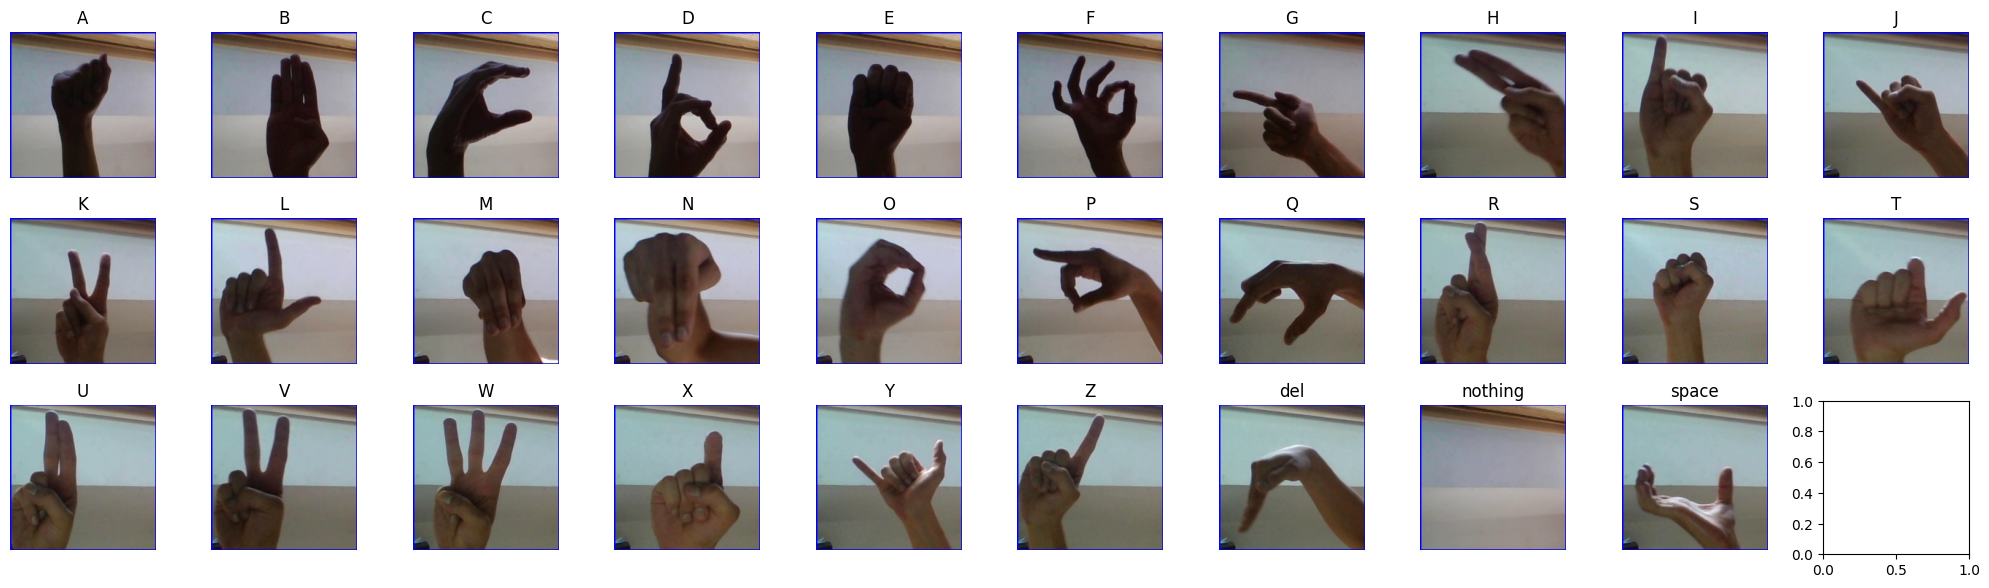

In [4]:
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
axes = axes.flatten()

for i, class_name in enumerate(classes[:30]):
    class_path = os.path.join(dataset_path, class_name)
    image_file = os.listdir(class_path)[0]
    image_path = os.path.join(class_path, image_file)
    
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
class_counts = {c: len(os.listdir(os.path.join(dataset_path, c))) for c in classes}
print(class_counts)

{'A': 3000, 'B': 3000, 'C': 3000, 'D': 3000, 'E': 3000, 'F': 3000, 'G': 3000, 'H': 3000, 'I': 3000, 'J': 3000, 'K': 3000, 'L': 3000, 'M': 3000, 'N': 3000, 'O': 3000, 'P': 3000, 'Q': 3000, 'R': 3000, 'S': 3000, 'T': 3000, 'U': 3000, 'V': 3000, 'W': 3000, 'X': 3000, 'Y': 3000, 'Z': 3000, 'del': 3000, 'nothing': 3000, 'space': 3000}


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import mixed_precision
from tensorflow.data import AUTOTUNE


In [7]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
img_size   = (128, 128)
batch_size = 64
train_dir  = "../data/asl_alphabet_train/asl_alphabet_train"  # adjust path as needed

In [9]:

# 1) Enable mixed‑precision and XLA
mixed_precision.set_global_policy('mixed_float16')
# tf.config.optimizer.set_jit(True)

# 2) Create tf.data Datasets directly
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=123,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=123,
)

# 3) Build a simple augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(*img_size),      # ensure exact size
    tf.keras.layers.Rescaling(1./255),        # rescale pixels
    tf.keras.layers.RandomRotation(0.1),      # ±10%
    tf.keras.layers.RandomZoom(0.1),          # ±10%
    tf.keras.layers.RandomTranslation(0.1,0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1),
    # no horizontal flip since hands are directional
])

# 4) Apply augmentation + performance ops
train_ds = (
    train_ds
    .map(lambda x,y: (data_augmentation(x, training=True), y),
         num_parallel_calls=AUTOTUNE)
    # .cache()
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(lambda x,y: (x/255., y), num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

# 5) Your optimizer stays the same
optimizer = tf.keras.optimizers.Adam(1e-4)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9
Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [10]:
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
  BatchNormalization(),
  MaxPooling2D(2, 2),

  Conv2D(64, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPooling2D(2, 2),

  Conv2D(128, (3, 3), activation='relu'),
  BatchNormalization(),
  MaxPooling2D(2, 2),

  Flatten(),
  Dropout(0.5),
  Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
  BatchNormalization(),
  Dropout(0.5),
  Dense(29, activation='softmax', dtype='float32')
])


In [11]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    # jit_compile=True,
)

# 1) Define your callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
ckpt     = ModelCheckpoint('best_sign_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_cb    = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


history = model.fit(
    train_ds,              # ← use tf.data.Dataset, not train_gen
    validation_data=val_ds, # ← ditto for your validation split
    epochs=20,
    callbacks=[early_stop, ckpt, lr_cb]
)

Epoch 1/20
1087/1088 [============================>.] - ETA: 0s - loss: 3.9582 - accuracy: 0.0602
Epoch 1: val_loss improved from inf to 4.40579, saving model to best_sign_model.h5
1088/1088 [==============================] - 186s 54ms/step - loss: 3.9580 - accuracy: 0.0601 - val_loss: 4.4058 - val_accuracy: 0.1312 - lr: 1.0000e-04
Epoch 2/20


KeyboardInterrupt: 

In [ ]:
model.save("models/sign_model.h5")

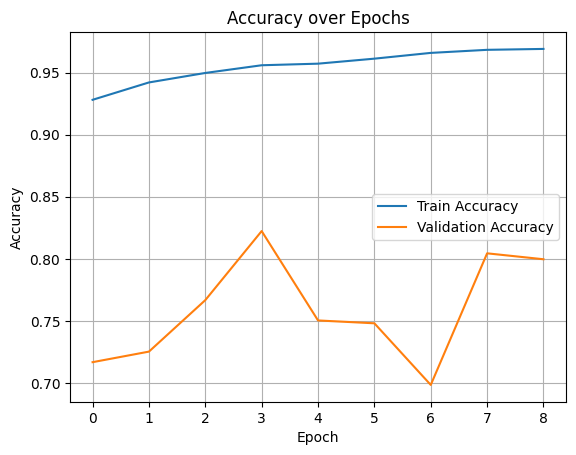

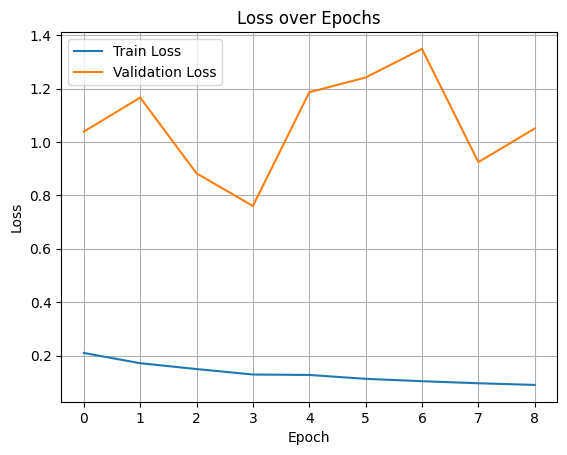

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()